In [1]:
import numpy as np
import pandas as pd
import requests
import json
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import kaleido
import plotly
import time

In [2]:
siret_data = pd.read_csv("./export_alimconfiance.csv", dtype=str, sep=";")

In [3]:
siret_data

,APP_Libelle_etablissement,SIRET,Adresse_2_UA,Code_postal,Libelle_commune,Numero_inspection,Date_inspection,APP_Libelle_activite_etablissement,Synthese_eval_sanit,Agrement,geores,filtre,ods_type_activite
0,DE CERGY NEUVILLE (SYND MIXTE D'ETUDE AMENA GE...,25950062700015,29 R DES ETANGS,95800,CERGY,16527453,2022-07-13T02:00:00+02:00,_,A améliorer,NaN,NaN,NaN,Autres
1,LE SAINT JOSEPH (RESTAURANT DE LA BOULANGERIE),31017429700013,46 R MERCIERE,69002,LYON,16463805,2022-04-05T02:00:00+02:00,Restaurant,Très satisfaisant,NaN,"45.762926,4.832648",Restaurant,Autres
2,MUSEE DE LA RENAISSANCE CHATEAU D'ECOUEN,16004612400014,R JEAN BULLANT,95440,ECOUEN,16354089,2022-02-17T01:00:00+01:00,_,Satisfaisant,NaN,"49.017271,2.380653",NaN,Autres
3,NATURALIA (NATURALIA FRANCE),30247464801894,36 RUE EUGENE EICHENBERGER,92800,PUTEAUX,16611978,2022-10-04T02:00:00+02:00,Alimentation générale,Satisfaisant,NaN,"48.881317,2.23746",Alimentation générale,Autres
4,SOCIETE CAPOCCI,31544532000031,CARRE A LA VIANDE,78000,VERSAILLES,16404936,2022-03-08T01:00:00+01:00,_,Satisfaisant,NaN,"48.797148,2.127159",NaN,Autres
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34448,GRANDJEAN,85278688800028,Zone d'activité Macon Est,01750,Replonges,22-074309-1,2022-09-15T02:00:00+02:00,Transformation de produits carnés,Très satisfaisant,01320001,"46.299555,4.897726",NaN,Viandes et produits carnés
34449,GRANDJEAN,85278688800028,Zone d'activité Macon Est,01750,Replonges,22-074059-1,2022-09-15T02:00:00+02:00,Production de produits à base d'escargots,Très satisfaisant,01320001,"46.299554,4.897724",NaN,Produits de la mer et d'eau douce
34450,OGEC SOC ELISABETH DE PLAISANC,77568307100010,12 RUE CROCE-SPINELLI,75014,Paris 14e Arrondissement,22-075149-1,2022-09-26T02:00:00+02:00,Restauration collective,Satisfaisant,NaN,"48.835253,2.3169",Restauration collective,Autres
34451,EURL LA ST CHRISTOPHE,48322532200021,route carrière,39130,Largillay-Marsonnay,22-066746-1,2022-08-29T02:00:00+02:00,Découpe de fromages,Satisfaisant,39278002,"46.553788,5.671371",NaN,Lait et produits laitiers


In [4]:
siret_data.shape

(34453, 13)

In [5]:
df_test = siret_data[["APP_Libelle_etablissement", "SIRET"]]

In [6]:
df_test.head(5)

,APP_Libelle_etablissement,SIRET
0,DE CERGY NEUVILLE (SYND MIXTE D'ETUDE AMENA GE...,25950062700015
1,LE SAINT JOSEPH (RESTAURANT DE LA BOULANGERIE),31017429700013
2,MUSEE DE LA RENAISSANCE CHATEAU D'ECOUEN,16004612400014
3,NATURALIA (NATURALIA FRANCE),30247464801894
4,SOCIETE CAPOCCI,31544532000031


In [7]:
df_test = df_test[df_test["APP_Libelle_etablissement"].str.len()>2]

In [8]:
def find(key, dictionary):
    for k, v in dictionary.items():
        if k == key:
            yield v
        elif isinstance(v, dict):
            for result in find(key, v):
                yield result
        elif isinstance(v, list):
            for d in v:
                for result in find(key, d):
                    yield result

In [9]:
import requests

from requests.adapters import HTTPAdapter, Retry

s = requests.Session()

retries = Retry(total=5,
                backoff_factor=10,
                status_forcelist=[ 500, 502, 503, 504 ])

s.mount('http://', HTTPAdapter(max_retries=retries))


In [10]:
def get_response(url, q):
    params["q"] = q
    response = s.get(url, params=params)
    time_elapsed = response.elapsed.total_seconds()
    content = json.loads(response.content)
    total_results = content["total_results"]
    total_pages = content["total_pages"]
    siren_list = [unite["siren"] for unite in content["results"]]
    siret_list = []
    for unite in content["results"]:
        for etablissement in unite["matching_etablissements"]:
            siret_list.append(etablissement["siret"])
    return total_results, total_pages, siren_list, siret_list, time_elapsed

In [11]:
url_elastic = "http://api.sirene.dataeng.etalab.studio/search"

In [12]:
# Get first 10 results
params = {"q": "", "page": "1", "per_page": "10"}

In [13]:
SEARCH_VERSION = 1

In [14]:
(
    df_test[f"results_elastic_{SEARCH_VERSION}"],
    df_test[f"pages_elastic_{SEARCH_VERSION}"],
    df_test[f"siren_elastic_{SEARCH_VERSION}"],
    df_test[f"siret_elastic_{SEARCH_VERSION}"],
    df_test[f"resp_time_elastic_{SEARCH_VERSION}"],
) = ("", "", "", "", "")

In [15]:
df_test

,APP_Libelle_etablissement,SIRET,results_elastic_1,pages_elastic_1,siren_elastic_1,siret_elastic_1,resp_time_elastic_1
0,DE CERGY NEUVILLE (SYND MIXTE D'ETUDE AMENA GE...,25950062700015,,,,,
1,LE SAINT JOSEPH (RESTAURANT DE LA BOULANGERIE),31017429700013,,,,,
2,MUSEE DE LA RENAISSANCE CHATEAU D'ECOUEN,16004612400014,,,,,
3,NATURALIA (NATURALIA FRANCE),30247464801894,,,,,
4,SOCIETE CAPOCCI,31544532000031,,,,,
...,...,...,...,...,...,...,...
34448,GRANDJEAN,85278688800028,,,,,
34449,GRANDJEAN,85278688800028,,,,,
34450,OGEC SOC ELISABETH DE PLAISANC,77568307100010,,,,,
34451,EURL LA ST CHRISTOPHE,48322532200021,,,,,


In [39]:
df_test = df_test.head(5000)

In [40]:
for index, row in df_test.iterrows():
    (
        df_test[f"results_elastic_{SEARCH_VERSION}"][index],
        df_test[f"pages_elastic_{SEARCH_VERSION}"][index],
        df_test[f"siren_elastic_{SEARCH_VERSION}"][index],
        df_test[f"siret_elastic_{SEARCH_VERSION}"][index],
        df_test[f"resp_time_elastic_{SEARCH_VERSION}"][index],
    ) = get_response(url_elastic, row["APP_Libelle_etablissement"])
    if index % 5 == 0: 
        time.sleep(0.5)

In [41]:
df_test

,APP_Libelle_etablissement,SIRET,results_elastic_1,pages_elastic_1,siren_elastic_1,siret_elastic_1,resp_time_elastic_1,siren,rank_siren_elastic_1,rank_siret_elastic_1,siren_socialGouv,siret_socialGouv,resp_time_socialGouv
0,DE CERGY NEUVILLE (SYND MIXTE D'ETUDE AMENA GE...,25950062700015,0.0,0.0,[],[],0.026526,259500627,-1,-1,"[259500627, 314406471, 257702985, 257801993, 2...","[25950062700015, 25950062700023, 3144064710001...",0.755867
1,LE SAINT JOSEPH (RESTAURANT DE LA BOULANGERIE),31017429700013,0.0,0.0,[],[],0.013440,310174297,-1,-1,"[802010173, 814039202, 310174297, 779158922, 3...","[80201017300010, 81403920200019, 3101742970001...",0.736387
2,MUSEE DE LA RENAISSANCE CHATEAU D'ECOUEN,16004612400014,4.0,1.0,"[160046124, 504382136, 427833017, 528172570]","[16004612400014, 50438213600019, 4278330170001...",0.040862,160046124,0,0,"[504382136, 160046124, 692041585, 802289819, 8...","[50438213600019, 16004612400014, 6920415850020...",0.665634
3,NATURALIA (NATURALIA FRANCE),30247464801894,4.0,1.0,"[302474648, 430277749, 334783644, 347736621]","[30247464800607, 30247464800789, 3024746480056...",0.070655,302474648,0,-1,"[302474648, 388635252, 794852897, 878105659, 8...","[30247464802272, 30247464800672, 3024746480097...",0.462358
4,SOCIETE CAPOCCI,31544532000031,2.0,1.0,"[315445320, 324815877]","[31544532000023, 31544532000031]",0.030673,315445320,0,1,"[315445320, 802626978, 530834605, 425039161, 4...","[31544532000031, 80262697800042, 5308346050004...",0.39759
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,LA POUPOUNETTO,33388076300029,1.0,1.0,[333880763],"[33388076300011, 33388076300029]",0.009626,333880763,0,1,,,
5001,GRAINE D OURS,34482479200347,2.0,1.0,"[344824792, 489431031]","[34482479200347, 48943103100017]",0.021182,344824792,0,0,,,
5002,LES PETITS CHAPERONS ROUGES,53913183900042,103.0,11.0,"[315363051, 853123149, 572102176, 528570229, 4...","[31536305100014, 31536305100030, 3153630510004...",0.484095,539131839,-1,-1,,,
5003,NOOK,88046764200026,24.0,3.0,"[901204727, 498658228, 914697768, 901520585, 8...","[90120472700019, 49865822800016, 4986582280002...",0.026287,880467642,-1,-1,,,


In [42]:
elastic_columns = [
    col
    for col in df_test.columns
    if "elastic" in col and ("result" in col or "pages" in col or "resp_time" in col)
]

In [43]:
df_test

,APP_Libelle_etablissement,SIRET,results_elastic_1,pages_elastic_1,siren_elastic_1,siret_elastic_1,resp_time_elastic_1,siren,rank_siren_elastic_1,rank_siret_elastic_1,siren_socialGouv,siret_socialGouv,resp_time_socialGouv
0,DE CERGY NEUVILLE (SYND MIXTE D'ETUDE AMENA GE...,25950062700015,0.0,0.0,[],[],0.026526,259500627,-1,-1,"[259500627, 314406471, 257702985, 257801993, 2...","[25950062700015, 25950062700023, 3144064710001...",0.755867
1,LE SAINT JOSEPH (RESTAURANT DE LA BOULANGERIE),31017429700013,0.0,0.0,[],[],0.013440,310174297,-1,-1,"[802010173, 814039202, 310174297, 779158922, 3...","[80201017300010, 81403920200019, 3101742970001...",0.736387
2,MUSEE DE LA RENAISSANCE CHATEAU D'ECOUEN,16004612400014,4.0,1.0,"[160046124, 504382136, 427833017, 528172570]","[16004612400014, 50438213600019, 4278330170001...",0.040862,160046124,0,0,"[504382136, 160046124, 692041585, 802289819, 8...","[50438213600019, 16004612400014, 6920415850020...",0.665634
3,NATURALIA (NATURALIA FRANCE),30247464801894,4.0,1.0,"[302474648, 430277749, 334783644, 347736621]","[30247464800607, 30247464800789, 3024746480056...",0.070655,302474648,0,-1,"[302474648, 388635252, 794852897, 878105659, 8...","[30247464802272, 30247464800672, 3024746480097...",0.462358
4,SOCIETE CAPOCCI,31544532000031,2.0,1.0,"[315445320, 324815877]","[31544532000023, 31544532000031]",0.030673,315445320,0,1,"[315445320, 802626978, 530834605, 425039161, 4...","[31544532000031, 80262697800042, 5308346050004...",0.39759
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,LA POUPOUNETTO,33388076300029,1.0,1.0,[333880763],"[33388076300011, 33388076300029]",0.009626,333880763,0,1,,,
5001,GRAINE D OURS,34482479200347,2.0,1.0,"[344824792, 489431031]","[34482479200347, 48943103100017]",0.021182,344824792,0,0,,,
5002,LES PETITS CHAPERONS ROUGES,53913183900042,103.0,11.0,"[315363051, 853123149, 572102176, 528570229, 4...","[31536305100014, 31536305100030, 3153630510004...",0.484095,539131839,-1,-1,,,
5003,NOOK,88046764200026,24.0,3.0,"[901204727, 498658228, 914697768, 901520585, 8...","[90120472700019, 49865822800016, 4986582280002...",0.026287,880467642,-1,-1,,,


In [44]:
for col in elastic_columns:
    df_test[col] = df_test[col].astype("float64")

In [45]:
df_test.describe()

,results_elastic_1,pages_elastic_1,resp_time_elastic_1,rank_siren_elastic_1,rank_siret_elastic_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,597.168200,60.303600,0.086696,0.195000,0.48720
std,2018.160934,201.711778,0.190091,1.539301,2.40728
min,0.000000,0.000000,0.004926,-1.000000,-1.00000
25%,1.000000,1.000000,0.019791,-1.000000,-1.00000
50%,4.000000,1.000000,0.032343,0.000000,0.00000
75%,57.000000,6.000000,0.060736,0.000000,1.00000
max,10000.000000,1000.000000,4.253675,9.000000,25.00000


In [46]:
df_test["siren"] = df_test["SIRET"].str[:9]

In [47]:
df_test.head(5)

,APP_Libelle_etablissement,SIRET,results_elastic_1,pages_elastic_1,siren_elastic_1,siret_elastic_1,resp_time_elastic_1,siren,rank_siren_elastic_1,rank_siret_elastic_1,siren_socialGouv,siret_socialGouv,resp_time_socialGouv
0,DE CERGY NEUVILLE (SYND MIXTE D'ETUDE AMENA GE...,25950062700015,0.0,0.0,[],[],0.026526,259500627,-1,-1,"[259500627, 314406471, 257702985, 257801993, 2...","[25950062700015, 25950062700023, 3144064710001...",0.755867
1,LE SAINT JOSEPH (RESTAURANT DE LA BOULANGERIE),31017429700013,0.0,0.0,[],[],0.013440,310174297,-1,-1,"[802010173, 814039202, 310174297, 779158922, 3...","[80201017300010, 81403920200019, 3101742970001...",0.736387
2,MUSEE DE LA RENAISSANCE CHATEAU D'ECOUEN,16004612400014,4.0,1.0,"[160046124, 504382136, 427833017, 528172570]","[16004612400014, 50438213600019, 4278330170001...",0.040862,160046124,0,0,"[504382136, 160046124, 692041585, 802289819, 8...","[50438213600019, 16004612400014, 6920415850020...",0.665634
3,NATURALIA (NATURALIA FRANCE),30247464801894,4.0,1.0,"[302474648, 430277749, 334783644, 347736621]","[30247464800607, 30247464800789, 3024746480056...",0.070655,302474648,0,-1,"[302474648, 388635252, 794852897, 878105659, 8...","[30247464802272, 30247464800672, 3024746480097...",0.462358
4,SOCIETE CAPOCCI,31544532000031,2.0,1.0,"[315445320, 324815877]","[31544532000023, 31544532000031]",0.030673,315445320,0,1,"[315445320, 802626978, 530834605, 425039161, 4...","[31544532000031, 80262697800042, 5308346050004...",0.39759


In [48]:
df_test[f"rank_siren_elastic_{SEARCH_VERSION}"] = ""

In [49]:
df_test[f"rank_siret_elastic_{SEARCH_VERSION}"] = ""

In [50]:
for ind, row in df_test.iterrows():
    if str(row["siren"]) in row[f"siren_elastic_{SEARCH_VERSION}"]:
        df_test[f"rank_siren_elastic_{SEARCH_VERSION}"][ind] = row[
            f"siren_elastic_{SEARCH_VERSION}"
        ].index(str(row["siren"]))
    else:
        df_test[f"rank_siren_elastic_{SEARCH_VERSION}"][ind] = -1

In [51]:
for ind, row in df_test.iterrows():
    if str(row["SIRET"]) in row[f"siret_elastic_{SEARCH_VERSION}"]:
        df_test[f"rank_siret_elastic_{SEARCH_VERSION}"][ind] = row[
            f"siret_elastic_{SEARCH_VERSION}"
        ].index(str(row["SIRET"]))
    else:
        df_test[f"rank_siret_elastic_{SEARCH_VERSION}"][ind] = -1

In [52]:
df_test.head(5)

,APP_Libelle_etablissement,SIRET,results_elastic_1,pages_elastic_1,siren_elastic_1,siret_elastic_1,resp_time_elastic_1,siren,rank_siren_elastic_1,rank_siret_elastic_1,siren_socialGouv,siret_socialGouv,resp_time_socialGouv
0,DE CERGY NEUVILLE (SYND MIXTE D'ETUDE AMENA GE...,25950062700015,0.0,0.0,[],[],0.026526,259500627,-1,-1,"[259500627, 314406471, 257702985, 257801993, 2...","[25950062700015, 25950062700023, 3144064710001...",0.755867
1,LE SAINT JOSEPH (RESTAURANT DE LA BOULANGERIE),31017429700013,0.0,0.0,[],[],0.013440,310174297,-1,-1,"[802010173, 814039202, 310174297, 779158922, 3...","[80201017300010, 81403920200019, 3101742970001...",0.736387
2,MUSEE DE LA RENAISSANCE CHATEAU D'ECOUEN,16004612400014,4.0,1.0,"[160046124, 504382136, 427833017, 528172570]","[16004612400014, 50438213600019, 4278330170001...",0.040862,160046124,0,0,"[504382136, 160046124, 692041585, 802289819, 8...","[50438213600019, 16004612400014, 6920415850020...",0.665634
3,NATURALIA (NATURALIA FRANCE),30247464801894,4.0,1.0,"[302474648, 430277749, 334783644, 347736621]","[30247464800607, 30247464800789, 3024746480056...",0.070655,302474648,0,-1,"[302474648, 388635252, 794852897, 878105659, 8...","[30247464802272, 30247464800672, 3024746480097...",0.462358
4,SOCIETE CAPOCCI,31544532000031,2.0,1.0,"[315445320, 324815877]","[31544532000023, 31544532000031]",0.030673,315445320,0,1,"[315445320, 802626978, 530834605, 425039161, 4...","[31544532000031, 80262697800042, 5308346050004...",0.39759


In [53]:
df_test[f"rank_siren_elastic_{SEARCH_VERSION}"] = df_test[
    f"rank_siren_elastic_{SEARCH_VERSION}"
].astype("int32")
df_test[f"rank_siret_elastic_{SEARCH_VERSION}"] = df_test[
    f"rank_siret_elastic_{SEARCH_VERSION}"
].astype("int32")

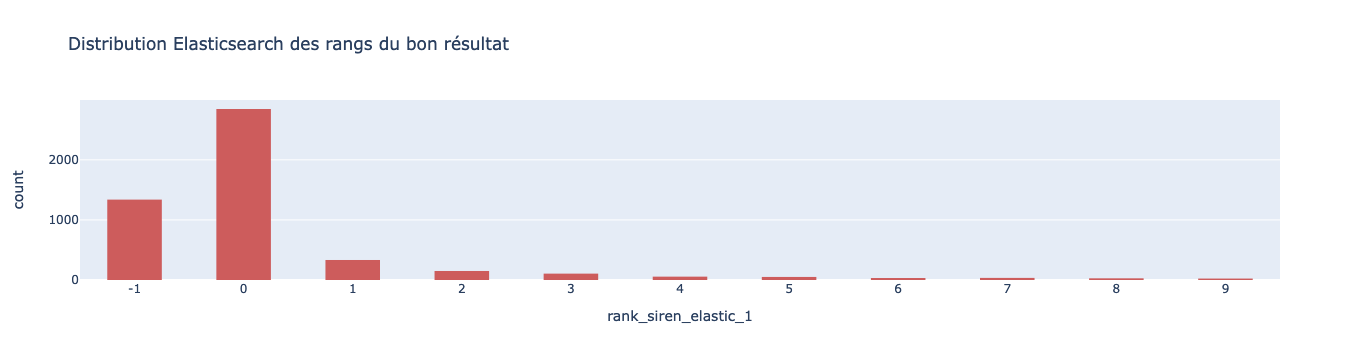

'./output/plots/rank_1.html'

In [54]:
fig = px.histogram(
    df_test.sort_values(by=[f"rank_siren_elastic_{SEARCH_VERSION}"]),
    x=f"rank_siren_elastic_{SEARCH_VERSION}",
    color_discrete_sequence=["indianred"],
    title="Distribution Elasticsearch des rangs du bon résultat",
)
fig.update_layout(bargap=0.5)
fig.update_xaxes(type="category")
fig.show()
plotly.offline.plot(fig, filename=f"./output/plots/rank_{SEARCH_VERSION}.html")

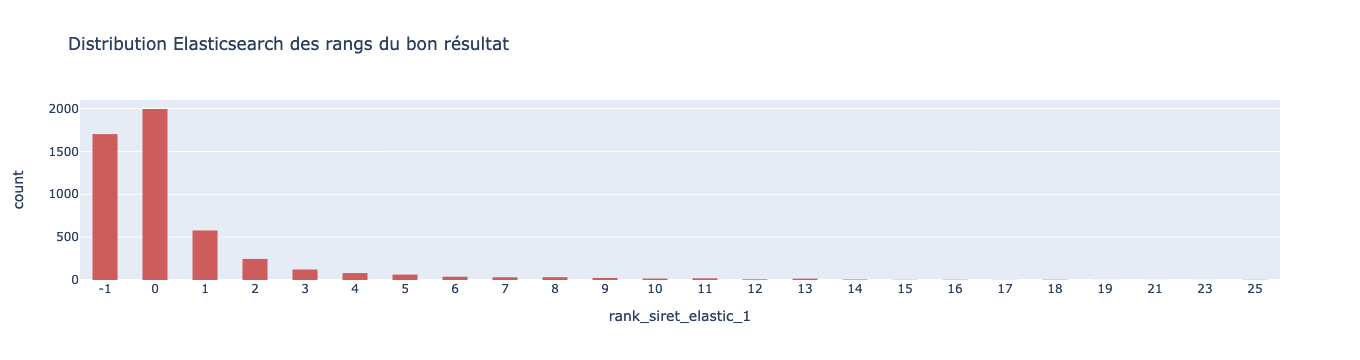

'./output/plots/rank_1.html'

In [55]:
fig = px.histogram(
    df_test.sort_values(by=[f"rank_siret_elastic_{SEARCH_VERSION}"]),
    x=f"rank_siret_elastic_{SEARCH_VERSION}",
    color_discrete_sequence=["indianred"],
    title="Distribution Elasticsearch des rangs du bon résultat",
)
fig.update_layout(bargap=0.5)
fig.update_xaxes(type="category")
fig.show()
plotly.offline.plot(fig, filename=f"./output/plots/rank_{SEARCH_VERSION}.html")

## Social gouv

In [56]:
social_gouv_url = "https://api.recherche-entreprises.fabrique.social.gouv.fr/api/v1/search?"

In [57]:
def get_response_socialGouv(url, q):
    params["query"] = q
    response = s.get(url, params=params)
    time_elapsed = response.elapsed.total_seconds()
    content = json.loads(response.content)
    # total_results = content["total_results"]
    # total_pages = content["total_pages"]
    siren_list = [unite["siren"] for unite in content["entreprises"]]
    siret_list = []
    for unite in content["entreprises"]:
        for etablissement in unite["allMatchingEtablissements"]:
            siret_list.append(etablissement["siret"])
    return siren_list, siret_list, time_elapsed

In [58]:
params = {"query": "", "limit": 10}

In [59]:
(
    df_test[f"siren_socialGouv"],
    df_test[f"siret_socialGouv"],
    df_test[f"resp_time_socialGouv"],
) = ("", "", "")

In [60]:
df_test

,APP_Libelle_etablissement,SIRET,results_elastic_1,pages_elastic_1,siren_elastic_1,siret_elastic_1,resp_time_elastic_1,siren,rank_siren_elastic_1,rank_siret_elastic_1,siren_socialGouv,siret_socialGouv,resp_time_socialGouv
0,DE CERGY NEUVILLE (SYND MIXTE D'ETUDE AMENA GE...,25950062700015,0.0,0.0,[],[],0.026526,259500627,-1,-1,,,
1,LE SAINT JOSEPH (RESTAURANT DE LA BOULANGERIE),31017429700013,0.0,0.0,[],[],0.013440,310174297,-1,-1,,,
2,MUSEE DE LA RENAISSANCE CHATEAU D'ECOUEN,16004612400014,4.0,1.0,"[160046124, 504382136, 427833017, 528172570]","[16004612400014, 50438213600019, 4278330170001...",0.040862,160046124,0,0,,,
3,NATURALIA (NATURALIA FRANCE),30247464801894,4.0,1.0,"[302474648, 430277749, 334783644, 347736621]","[30247464800607, 30247464800789, 3024746480056...",0.070655,302474648,0,-1,,,
4,SOCIETE CAPOCCI,31544532000031,2.0,1.0,"[315445320, 324815877]","[31544532000023, 31544532000031]",0.030673,315445320,0,1,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,LA POUPOUNETTO,33388076300029,1.0,1.0,[333880763],"[33388076300011, 33388076300029]",0.009626,333880763,0,1,,,
5001,GRAINE D OURS,34482479200347,2.0,1.0,"[344824792, 489431031]","[34482479200347, 48943103100017]",0.021182,344824792,0,0,,,
5002,LES PETITS CHAPERONS ROUGES,53913183900042,103.0,11.0,"[315363051, 853123149, 572102176, 528570229, 4...","[31536305100014, 31536305100030, 3153630510004...",0.484095,539131839,-1,-1,,,
5003,NOOK,88046764200026,24.0,3.0,"[901204727, 498658228, 914697768, 901520585, 8...","[90120472700019, 49865822800016, 4986582280002...",0.026287,880467642,-1,-1,,,


In [61]:
for index, row in df_test.iterrows():
    (
        df_test["siren_socialGouv"][index],
        df_test[f"siret_socialGouv"][index],
        df_test[f"resp_time_socialGouv"][index],
    ) = get_response_socialGouv(social_gouv_url, row["APP_Libelle_etablissement"])
    if index % 5 == 0: 
        time.sleep(0.5)

In [62]:
df_test

,APP_Libelle_etablissement,SIRET,results_elastic_1,pages_elastic_1,siren_elastic_1,siret_elastic_1,resp_time_elastic_1,siren,rank_siren_elastic_1,rank_siret_elastic_1,siren_socialGouv,siret_socialGouv,resp_time_socialGouv
0,DE CERGY NEUVILLE (SYND MIXTE D'ETUDE AMENA GE...,25950062700015,0.0,0.0,[],[],0.026526,259500627,-1,-1,"[259500627, 314406471, 257702985, 257801993, 2...","[25950062700015, 25950062700023, 3144064710001...",0.759042
1,LE SAINT JOSEPH (RESTAURANT DE LA BOULANGERIE),31017429700013,0.0,0.0,[],[],0.013440,310174297,-1,-1,"[802010173, 814039202, 310174297, 779158922, 3...","[80201017300010, 81403920200019, 3101742970001...",0.725018
2,MUSEE DE LA RENAISSANCE CHATEAU D'ECOUEN,16004612400014,4.0,1.0,"[160046124, 504382136, 427833017, 528172570]","[16004612400014, 50438213600019, 4278330170001...",0.040862,160046124,0,0,"[504382136, 160046124, 692041585, 802289819, 8...","[50438213600019, 16004612400014, 6920415850020...",0.660334
3,NATURALIA (NATURALIA FRANCE),30247464801894,4.0,1.0,"[302474648, 430277749, 334783644, 347736621]","[30247464800607, 30247464800789, 3024746480056...",0.070655,302474648,0,-1,"[302474648, 388635252, 794852897, 878105659, 8...","[30247464802272, 30247464800672, 3024746480097...",0.463444
4,SOCIETE CAPOCCI,31544532000031,2.0,1.0,"[315445320, 324815877]","[31544532000023, 31544532000031]",0.030673,315445320,0,1,"[315445320, 802626978, 530834605, 425039161, 4...","[31544532000031, 80262697800042, 5308346050004...",0.400556
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,LA POUPOUNETTO,33388076300029,1.0,1.0,[333880763],"[33388076300011, 33388076300029]",0.009626,333880763,0,1,"[333880763, 512162835, 914432745, 503686206, 4...","[33388076300029, 51216283500015, 5121628350002...",0.208323
5001,GRAINE D OURS,34482479200347,2.0,1.0,"[344824792, 489431031]","[34482479200347, 48943103100017]",0.021182,344824792,0,0,"[843120411, 920129954, 829263623, 901150359, 5...","[84312041100015, 84312041100023, 9201299540001...",0.183261
5002,LES PETITS CHAPERONS ROUGES,53913183900042,103.0,11.0,"[315363051, 853123149, 572102176, 528570229, 4...","[31536305100014, 31536305100030, 3153630510004...",0.484095,539131839,-1,-1,"[315363051, 853123149, 811397298, 792715336, 4...","[31536305100030, 31536305100048, 3153630510005...",0.377369
5003,NOOK,88046764200026,24.0,3.0,"[901204727, 498658228, 914697768, 901520585, 8...","[90120472700019, 49865822800016, 4986582280002...",0.026287,880467642,-1,-1,"[883842965, 804362556, 428988398, 920514692, 4...","[88384296500013, 80436255600032, 4289883980003...",0.070693


In [63]:
df_test[f"rank_siren_socialGouv"] = ""

In [64]:
df_test[f"rank_siret_socialGouv"] = ""

In [65]:
for ind, row in df_test.iterrows():
    if str(row["siren"]) in row[f"siren_socialGouv"]:
        df_test[f"rank_siren_socialGouv"][ind] = row[
            f"siren_socialGouv"
        ].index(str(row["siren"]))
    else:
        df_test[f"rank_siren_socialGouv"][ind] = -1

In [66]:
for ind, row in df_test.iterrows():
    if str(row["SIRET"]) in row[f"siret_socialGouv"]:
        df_test[f"rank_siret_socialGouv"][ind] = row[
            f"siret_socialGouv"
        ].index(str(row["SIRET"]))
    else:
        df_test[f"rank_siret_socialGouv"][ind] = -1

In [67]:
df_test

,APP_Libelle_etablissement,SIRET,results_elastic_1,pages_elastic_1,siren_elastic_1,siret_elastic_1,resp_time_elastic_1,siren,rank_siren_elastic_1,rank_siret_elastic_1,siren_socialGouv,siret_socialGouv,resp_time_socialGouv,rank_siren_socialGouv,rank_siret_socialGouv
0,DE CERGY NEUVILLE (SYND MIXTE D'ETUDE AMENA GE...,25950062700015,0.0,0.0,[],[],0.026526,259500627,-1,-1,"[259500627, 314406471, 257702985, 257801993, 2...","[25950062700015, 25950062700023, 3144064710001...",0.759042,0,0
1,LE SAINT JOSEPH (RESTAURANT DE LA BOULANGERIE),31017429700013,0.0,0.0,[],[],0.013440,310174297,-1,-1,"[802010173, 814039202, 310174297, 779158922, 3...","[80201017300010, 81403920200019, 3101742970001...",0.725018,2,2
2,MUSEE DE LA RENAISSANCE CHATEAU D'ECOUEN,16004612400014,4.0,1.0,"[160046124, 504382136, 427833017, 528172570]","[16004612400014, 50438213600019, 4278330170001...",0.040862,160046124,0,0,"[504382136, 160046124, 692041585, 802289819, 8...","[50438213600019, 16004612400014, 6920415850020...",0.660334,1,1
3,NATURALIA (NATURALIA FRANCE),30247464801894,4.0,1.0,"[302474648, 430277749, 334783644, 347736621]","[30247464800607, 30247464800789, 3024746480056...",0.070655,302474648,0,-1,"[302474648, 388635252, 794852897, 878105659, 8...","[30247464802272, 30247464800672, 3024746480097...",0.463444,0,-1
4,SOCIETE CAPOCCI,31544532000031,2.0,1.0,"[315445320, 324815877]","[31544532000023, 31544532000031]",0.030673,315445320,0,1,"[315445320, 802626978, 530834605, 425039161, 4...","[31544532000031, 80262697800042, 5308346050004...",0.400556,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,LA POUPOUNETTO,33388076300029,1.0,1.0,[333880763],"[33388076300011, 33388076300029]",0.009626,333880763,0,1,"[333880763, 512162835, 914432745, 503686206, 4...","[33388076300029, 51216283500015, 5121628350002...",0.208323,0,0
5001,GRAINE D OURS,34482479200347,2.0,1.0,"[344824792, 489431031]","[34482479200347, 48943103100017]",0.021182,344824792,0,0,"[843120411, 920129954, 829263623, 901150359, 5...","[84312041100015, 84312041100023, 9201299540001...",0.183261,-1,-1
5002,LES PETITS CHAPERONS ROUGES,53913183900042,103.0,11.0,"[315363051, 853123149, 572102176, 528570229, 4...","[31536305100014, 31536305100030, 3153630510004...",0.484095,539131839,-1,-1,"[315363051, 853123149, 811397298, 792715336, 4...","[31536305100030, 31536305100048, 3153630510005...",0.377369,-1,-1
5003,NOOK,88046764200026,24.0,3.0,"[901204727, 498658228, 914697768, 901520585, 8...","[90120472700019, 49865822800016, 4986582280002...",0.026287,880467642,-1,-1,"[883842965, 804362556, 428988398, 920514692, 4...","[88384296500013, 80436255600032, 4289883980003...",0.070693,-1,-1


In [68]:
df_test[f"rank_siren_socialGouv"] = df_test[
    f"rank_siren_socialGouv"
].astype("int32")
df_test[f"rank_siret_socialGouv"] = df_test[
    f"rank_siret_socialGouv"
].astype("int32")

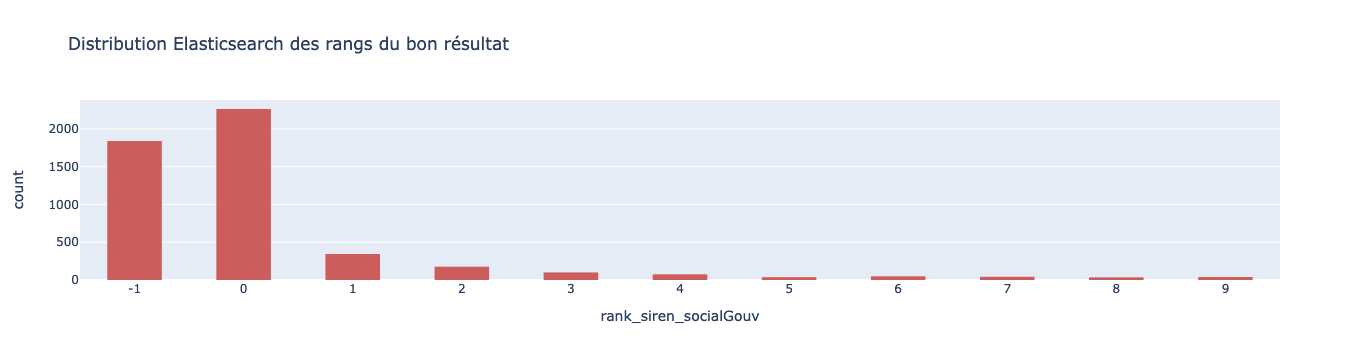

'./output/plots/rank_socialGouv.html'

In [69]:
fig = px.histogram(
    df_test.sort_values(by=[f"rank_siren_socialGouv"]),
    x=f"rank_siren_socialGouv",
    color_discrete_sequence=["indianred"],
    title="Distribution Elasticsearch des rangs du bon résultat",
)
fig.update_layout(bargap=0.5)
fig.update_xaxes(type="category")
fig.show()
plotly.offline.plot(fig, filename=f"./output/plots/rank_socialGouv.html")

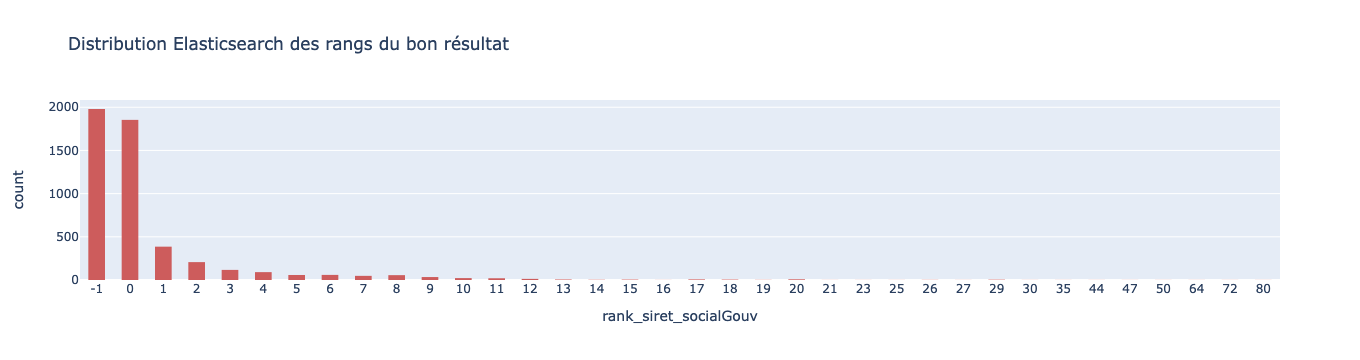

'./output/plots/rank_socialGouv.html'

In [70]:
fig = px.histogram(
    df_test.sort_values(by=[f"rank_siret_socialGouv"]),
    x=f"rank_siret_socialGouv",
    color_discrete_sequence=["indianred"],
    title="Distribution Elasticsearch des rangs du bon résultat",
)
fig.update_layout(bargap=0.5)
fig.update_xaxes(type="category")
fig.show()
plotly.offline.plot(fig, filename=f"./output/plots/rank_socialGouv.html")

In [71]:
rank_siren_columns = [col for col in df_test.columns if "rank_siren" in col]

In [72]:
rank_siren_columns

['rank_siren_elastic_1', 'rank_siren_socialGouv']

In [73]:
rank_siret_columns = [col for col in df_test.columns if "rank_siret" in col]

In [74]:
rank_siret_columns

['rank_siret_elastic_1', 'rank_siret_socialGouv']

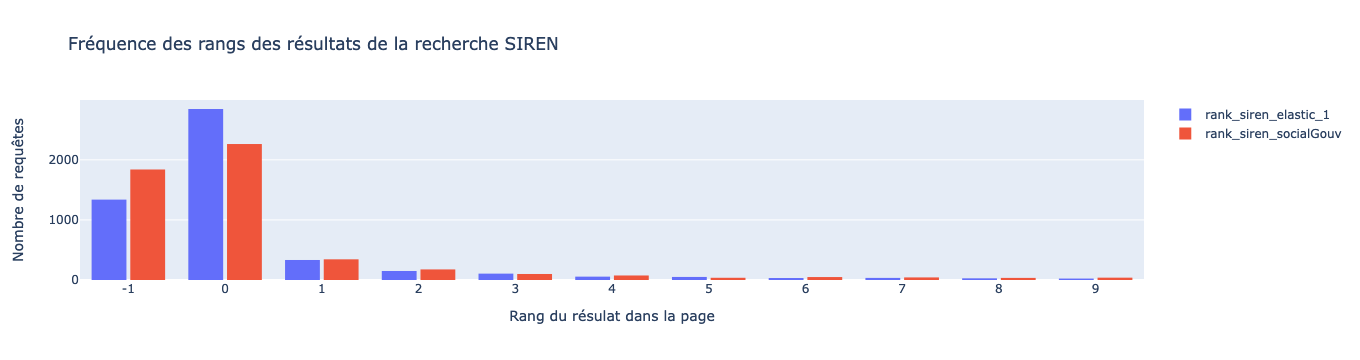

'./output/plots/rank_war_1.html'

In [78]:
fig = go.Figure()
rank_dict = {}
for rank in rank_siren_columns:
    df_test[rank] = df_test[rank].astype("int32")
    rank_dict[rank] = df_test.sort_values(by=[rank])[rank]
    fig.add_trace(
        go.Histogram(
            histfunc="count",
            x=rank_dict[rank],
            name=rank,
        )
    )
fig.update_layout(
    title_text="Fréquence des rangs des résultats de la recherche SIREN",  # title of plot
    xaxis_title_text="Rang du résulat dans la page",  # xaxis label
    yaxis_title_text="Nombre de requêtes",  # yaxis label
    bargap=0.2,  # gap between bars of adjacent location coordinates
    bargroupgap=0.1,  # gap between bars of the same location coordinates
)
fig.update_xaxes(type="category")
fig.show()
# fig.write_image(f"./output/plots/rank_{SEARCH_VERSION}.png")
plotly.offline.plot(fig, filename=f"./output/plots/rank_war_{SEARCH_VERSION}.html")

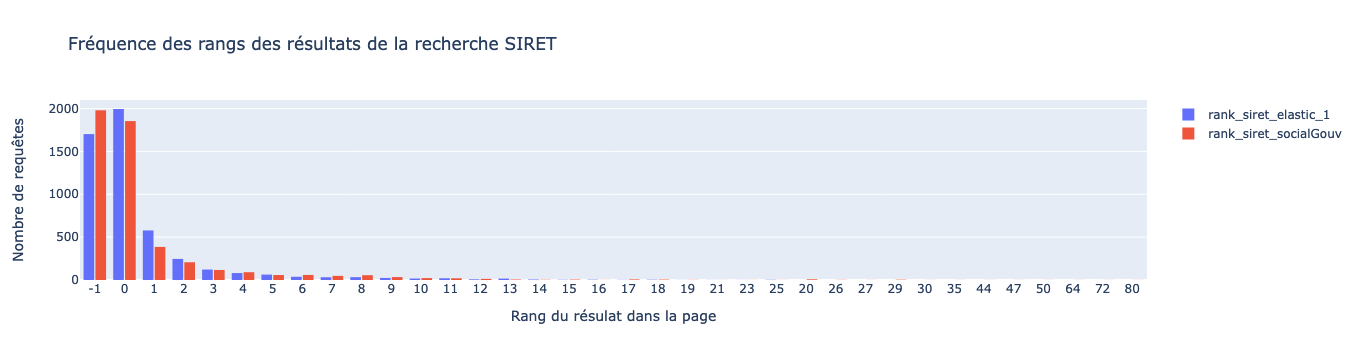

'./output/plots/rank_war_1.html'

In [79]:
fig = go.Figure()
rank_dict = {}
for rank in rank_siret_columns:
    df_test[rank] = df_test[rank].astype("int32")
    rank_dict[rank] = df_test.sort_values(by=[rank])[rank]
    fig.add_trace(
        go.Histogram(
            histfunc="count",
            x=rank_dict[rank],
            name=rank,
        )
    )
fig.update_layout(
    title_text="Fréquence des rangs des résultats de la recherche SIRET",  # title of plot
    xaxis_title_text="Rang du résulat dans la page",  # xaxis label
    yaxis_title_text="Nombre de requêtes",  # yaxis label
    bargap=0.2,  # gap between bars of adjacent location coordinates
    bargroupgap=0.1,  # gap between bars of the same location coordinates
)
fig.update_xaxes(type="category")
fig.show()
# fig.write_image(f"./output/plots/rank_{SEARCH_VERSION}.png")
plotly.offline.plot(fig, filename=f"./output/plots/rank_war_{SEARCH_VERSION}.html")

In [80]:
df_test.tail(10)

,APP_Libelle_etablissement,SIRET,results_elastic_1,pages_elastic_1,siren_elastic_1,siret_elastic_1,resp_time_elastic_1,siren,rank_siren_elastic_1,rank_siret_elastic_1,siren_socialGouv,siret_socialGouv,resp_time_socialGouv,rank_siren_socialGouv,rank_siret_socialGouv
4995,COMITE DE GESTION DU CV DANIELLE CASANOVA,79083367700012,0.0,0.0,[],[],0.015462,790833677,-1,-1,"[753596063, 393774468, 777303850, 907510499, 4...","[75359606300010, 39377446800010, 7773038500005...",0.560081,-1,-1
4996,OGEC ENSEMBLE SCOLAIRE ST FRANCOIS D'ASSISE,77623408000039,1.0,1.0,[776234080],"[77623408000013, 77623408000021, 77623408000039]",0.030381,776234080,0,2,"[776234080, 775344963, 532345501, 783496144, 4...","[77623408000013, 77623408000039, 7753449630003...",0.737214,0,1
4997,PISCICULTURE DE LA MOTTE,89863154400019,3.0,1.0,"[898631544, 342904398, 388250417]","[89863154400019, 34290439800019, 38825041700010]",0.023746,898631544,0,0,"[898631544, 895046340, 452820434, 409618253, 8...","[89863154400019, 89504634000017, 8950463400002...",0.329873,0,0
4998,HASSANE SITT-NOUROU,P00033222001,0.0,0.0,[],[],0.007985,P00033222,-1,-1,"[781456769, 884369869, 830128963, 899567655, 8...","[78145676900038, 78145676900046, 7814567690005...",0.28538,-1,-1
4999,LE CONTINENTAL,81450183900017,2143.0,215.0,"[775670284, 615820776, 410276679, 380110304, 3...","[77567028405260, 77567028405278, 7756702840528...",0.228879,814501839,-1,-1,"[775670284, 409449923, 380110304, 332266220, 3...","[77567028405278, 77567028402515, 7756702840139...",0.240904,-1,-1
5000,LA POUPOUNETTO,33388076300029,1.0,1.0,[333880763],"[33388076300011, 33388076300029]",0.009626,333880763,0,1,"[333880763, 512162835, 914432745, 503686206, 4...","[33388076300029, 51216283500015, 5121628350002...",0.208323,0,0
5001,GRAINE D OURS,34482479200347,2.0,1.0,"[344824792, 489431031]","[34482479200347, 48943103100017]",0.021182,344824792,0,0,"[843120411, 920129954, 829263623, 901150359, 5...","[84312041100015, 84312041100023, 9201299540001...",0.183261,-1,-1
5002,LES PETITS CHAPERONS ROUGES,53913183900042,103.0,11.0,"[315363051, 853123149, 572102176, 528570229, 4...","[31536305100014, 31536305100030, 3153630510004...",0.484095,539131839,-1,-1,"[315363051, 853123149, 811397298, 792715336, 4...","[31536305100030, 31536305100048, 3153630510005...",0.377369,-1,-1
5003,NOOK,88046764200026,24.0,3.0,"[901204727, 498658228, 914697768, 901520585, 8...","[90120472700019, 49865822800016, 4986582280002...",0.026287,880467642,-1,-1,"[883842965, 804362556, 428988398, 920514692, 4...","[88384296500013, 80436255600032, 4289883980003...",0.070693,-1,-1
5004,COLLÈGE D'ESPAGNE,34420912700010,21.0,3.0,"[812160331, 191316025, 632041042, 344209127, 3...","[81216033100011, 19131602500011, 6320410421248...",0.372773,344209127,3,3,"[797582616, 812160331, 508195732, 499942415, 4...","[79758261600018, 81216033100011, 5081957320001...",0.280824,6,6


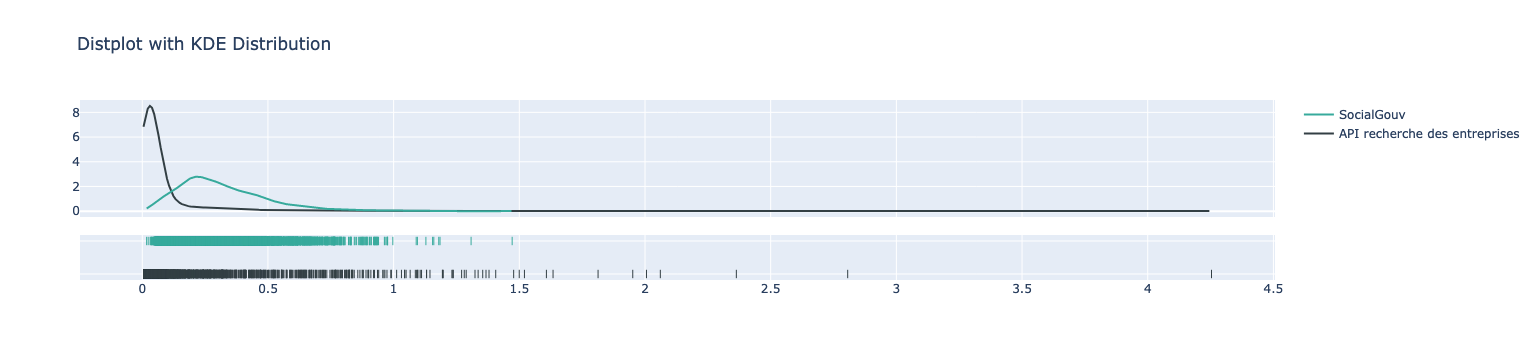

In [110]:
import plotly.figure_factory as ff
import numpy as np

# Add histogram data
x1 = df_test["resp_time_elastic_1"]
x2 = df_test["resp_time_socialGouv"]
colors = ['#333F44', '#37AA9C']


# Group data together
hist_data = [x1, x2]

group_labels = ['API recherche des entreprises', 'SocialGouv']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, show_hist=False,  colors=colors)
fig.update_layout(title_text='Distplot with KDE Distribution')
fig.show()

In [106]:
import seaborn as sns

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



<AxesSubplot:ylabel='Density'>

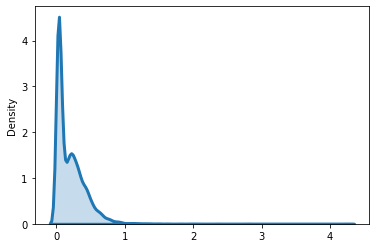

In [111]:
sns.distplot(df_test[['resp_time_elastic_1',"resp_time_socialGouv"]], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "elastic")